In [2]:
import os
import boto3
import tarfile

In [3]:
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = l'

In [4]:
session = boto3.Session(
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
s3 = boto3.client('s3')

s3.download_file('sagemaker-us-east-2-561323288832',
                 'rf-scikit-2020-10-30-10-41-32-087/output/model.tar.gz',
                 'model.tar.gz')

tar = tarfile.open('model.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [5]:
from azureml.core import Workspace

ws = Workspace.get(name="ajg",
                    subscription_id='df21e948-9b6b-4c98-a2d2-de09e55c34d8',
                    resource_group='miax5')

In [6]:
from azureml.core.model import Model
model = Model.register(model_path = "model.joblib",
                        model_name = "bme_isotonic",
                        description = "BME AJG Isotonic Regression",
                        workspace = ws)


Registering model bme_isotonic


In [7]:
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# Create the environment
myenv = Environment(name="myenv")
conda_dep = CondaDependencies()

# Define the packages needed by the model and scripts
conda_dep.add_conda_package("pandas")
conda_dep.add_conda_package("scikit-learn")
conda_dep.add_conda_package("numpy")
# You must list azureml-defaults as a pip dependency
conda_dep.add_pip_package("azureml-defaults")

# Adds dependencies to PythonSection of myenv
myenv.python.conda_dependencies=conda_dep

inference_config = InferenceConfig(entry_script="script.py",
                                   environment=myenv)

In [8]:
from azureml.core.webservice import LocalWebservice

deployment_config = LocalWebservice.deploy_configuration()

In [9]:
from azureml.core.model import Model

model = Model(ws, name="bme_isotonic")
service = Model.deploy(ws, 'myservice', [model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)
print("scoring URI: " + service.scoring_uri)

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 5d2d3b530c3d4082b84a4176bb8fc15a.azurecr.io
Logging into Docker registry 5d2d3b530c3d4082b84a4176bb8fc15a.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 5d2d3b530c3d4082b84a4176bb8fc15a.azurecr.io/azureml/azureml_46a81e82cfb6bc4cdf2ad0452b2ab68a
 ---> 7418682aff13
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> e5c677ac6b16
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImRmMjFlOTQ4LTliNmItNGM5OC1hMmQyLWRlMDllNTVjMzRkOCIsInJlc291cmNlR3JvdXBOYW1lIjoibWlheDUiLCJhY2NvdW50TmFtZSI6ImFqZyIsIndvcmtzcGFjZUlkIjoiNWQyZDNiNTMtMGMzZC00MDgyLWI4NGEtNDE3NmJiOGZjMTVhIn0sIm1vZGVscyI6e30sIm1vZGVsc0luZm8iOnt9fQ== | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 1f1b88b05b0f
 ---> e9b5cebb38c6
Step 4/5 : RUN mv '/var/azureml-app/tmps9vcnvze.py' /var/azureml-app/main.py
 ---> Running in 7f783579280f
 ---> d6530ced2864

In [10]:
import requests
import json

scoring_uri = 'http://localhost:32769/score'
headers = {'Content-Type':'application/json'}

In [11]:
test_data = json.dumps({'number':  [1.2]})

response = requests.post(scoring_uri, data=test_data, headers=headers)
print(response.status_code)
print(response.elapsed)
print(response.json())

200
0:00:00.053068
{'pred': '[1.20171548]'}


In [12]:
import pandas as pd
import numpy as np

In [13]:
data = pd.read_csv('s3://sagemakerbmeironia/sagemaker_input_data/data.csv', sep=';')
data.set_index('date_ws', inplace=True)

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='ffill', inplace=True)
    check_equal_df = data.equals(data_pre)

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='bfill', inplace=True)
    check_equal_df = data.equals(data_pre)
    
returns = np.log(data).diff()

market = returns.mean(axis=1)
market.iloc[0] = 1
market_cum = market.cumsum()
inputs = market_cum[:-1]
target = market_cum[1:]

In [14]:
perc_train = 0.7
perc_test = 0.2

In [15]:
train_x, train_y = inputs.iloc[:int(len(inputs)*perc_train)] , target.iloc[:int(len(inputs)*perc_train)]
test_x, test_y = inputs.iloc[int(len(inputs)*perc_train):int(len(inputs)*(perc_train+perc_test))] , target.iloc[int(len(inputs)*perc_train):int(len(inputs)*(perc_train+perc_test))]
val_x, val_y = inputs.iloc[int(len(inputs)*(perc_train+perc_test)):] , target.iloc[int(len(inputs)*(perc_train+perc_test)):]

In [16]:
predictions = []
for elem in val_x.tolist():
    test_data = json.dumps({'number':  [elem]})
    response = requests.post(scoring_uri, data=test_data, headers=headers)
    pred_str = response.json()['pred']
    pred = float(pred_str.split('[')[1].split(']')[0])
    predictions.append(pred)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

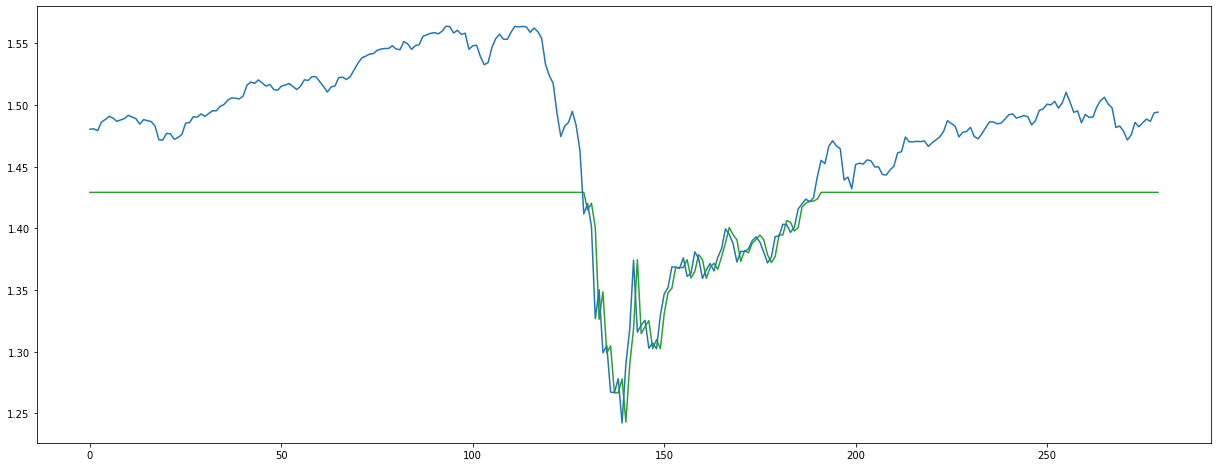

In [18]:
fig, ax1 = plt.subplots()
ax1.plot(predictions, color='tab:green')
ax1.plot(val_y.tolist(), color='tab:blue')
fig.tight_layout()
fig.set_size_inches(18.5, 7, forward=True)
plt.show()

In [19]:
from sklearn.metrics import r2_score
r2_score(val_y.tolist(), predictions)

-0.12299566470877377